## Numerical experiments math and Data Science Project
#### Authors: Beltrame and Marchionne

In the following, we are presenting the results of the numerical experiments associated to the following papers:

- Training ReLU networks to high uniform accuracy is intractable; Julius Berner; Philipp Grohs and Felix Voigtlaender


The numerical experiments aim to prove that we can find relevant and domain-specific problems of usign neural networks in solving even simple tasks.


## Target function: x $\rightarrow$ log(sin(50x) + 2) + sin(5x)

In the next line we are implementing a Student Teacher Neural Network regressor.

The Student-Teacher Framework is a machine learning approach where a "student" model is trained to mimic the outputs of a pre-trained "teacher" model. The student model is typically smaller and faster, while the teacher model is larger and slower, but more accurate. During training, the student model is fed input data and its predictions are compared to the ground-truth labels produced by the teacher model. The student model's parameters are then updated based on this comparison, until the student's predictions match the teacher's predictions with high accuracy. The end result is a compact, efficient model that has learned from the knowledge of a larger, more accurate model.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim

from sklearn.neural_network import MLPRegressor

    
# custom
from Functions import plot_result, create_dataset, StudentTeacher, ModelEvaluator, StudentNet, TeacherNet

## Data

Since we had to discretize we chose to use as the ground truth a function with a point each 0.0001 unit of distance.
This corresponds to out fine grain resolution for the problem. 

It would be possible to increase the resolution but this would take quite a lot of computational time.

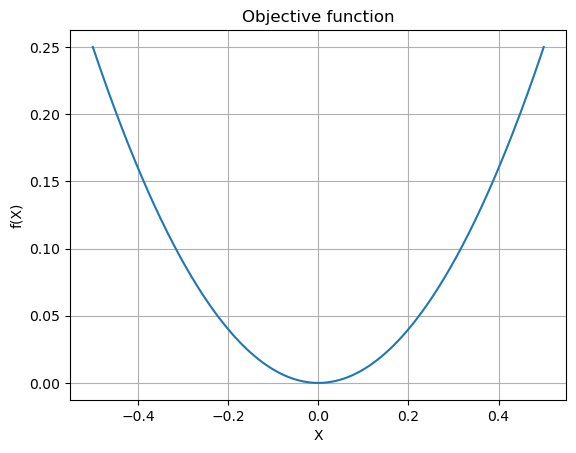

In [2]:
# define x
epsilon = 0.0001
x = np.arange(-0.5, 0.5, epsilon)
x_init = x
function = lambda x : x*x
fx = [function(e) for e in x]
plot_result(x_init, fx, "X", "f(X)", "Objective function")

x_train, x_test, y_train, y_test = create_dataset(x, fx)

[]

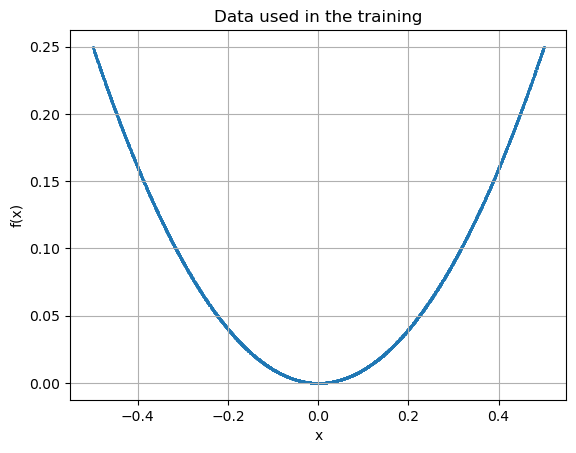

In [3]:
plt.scatter(x_train, y_train, 1)
plt.title("Data used in the training")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()
plt.plot()

## Simple regressor

In [4]:
regr = MLPRegressor(random_state=42, max_iter=500).fit(x_train, y_train)

C:\Users\beltr\anaconda3\envs\math\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
epsilon = 10
x_unif = np.linspace(-0.5, 0.5, epsilon).reshape(-1, 1) 
preds = regr.predict(x_test)
preds_unif = regr.predict(x_unif)
print("The score on the training set is: ", regr.score(x_test, y_test))
print("The score on the constant resolution, epsilon = 10, is: ", regr.score(x_unif, [function(e) for e in x_unif]))

The score on the training set is:  0.97164303518082
The score on the constant resolution, epsilon = 10, is:  0.956138767153742


The scores seem to be comparable in terms of R2 score. Let's analyse the scores induced by the L1, the L2 and the L-infinity norms. 

In [6]:
compute_errors(preds, y_test)

NameError: name 'compute_errors' is not defined

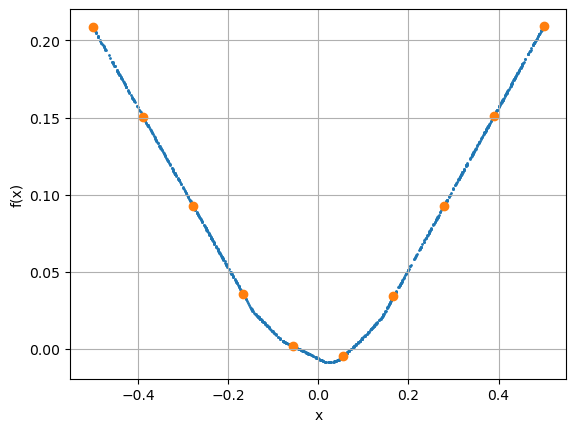

In [20]:
plt.scatter(x_test, preds, s=1, label="Test set")
plt.scatter(x_unif, preds_unif, label="Epsilon = 10 Uniform")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()

The results are good, we do not observe noticeable drifts from the main function. 

We now increase the epsilon value

In [21]:
def compute_errors(predictions, targets):
    l1_error = np.mean(np.abs(predictions - targets))
    l2_error = np.mean(np.square(predictions - targets))
    linf_error = np.max(np.abs(predictions - targets))
    
    print("L1 Error: {:.4f}".format(l1_error))
    print("L2 Error: {:.4f}".format(l2_error))
    print("L-inf Error: {:.4f}".format(linf_error))

In [4]:
class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def predict(self, x):
        with torch.no_grad():
            return self.forward(x)
        
    def train(self, inputs, targets, epochs, learning_rate, batch_size, criterion=nn.MSELoss(), optimizer=optim.SGD):
        optimizer = optimizer(self.parameters(), lr=learning_rate)
        for epoch in range(epochs):
            for i in range(0, inputs.size(0), batch_size):
                inputs_batch = inputs[i:i+batch_size]
                targets_batch = targets[i:i+batch_size]
                
                optimizer.zero_grad()
                outputs = self(inputs_batch)
                loss = criterion(outputs, targets_batch)
                loss.backward()
                optimizer.step()
                
            print("Epoch {}/{}, Loss: {:.4f}".format(epoch+1, epochs, loss.item()))

In [6]:
# Train the model
model = MLPRegressor(input_dim=1, hidden_dim = 10, output_dim=1)
model.train(x_train, y_train, epochs=100, learning_rate = 0.001, batch_size = 100)

Epoch 1/100, Loss: 0.2201
Epoch 2/100, Loss: 0.1675
Epoch 3/100, Loss: 0.1291
Epoch 4/100, Loss: 0.1006
Epoch 5/100, Loss: 0.0791
Epoch 6/100, Loss: 0.0627
Epoch 7/100, Loss: 0.0501
Epoch 8/100, Loss: 0.0404
Epoch 9/100, Loss: 0.0328
Epoch 10/100, Loss: 0.0269
Epoch 11/100, Loss: 0.0223
Epoch 12/100, Loss: 0.0187
Epoch 13/100, Loss: 0.0158
Epoch 14/100, Loss: 0.0136
Epoch 15/100, Loss: 0.0118
Epoch 16/100, Loss: 0.0104
Epoch 17/100, Loss: 0.0093
Epoch 18/100, Loss: 0.0084
Epoch 19/100, Loss: 0.0077
Epoch 20/100, Loss: 0.0072
Epoch 21/100, Loss: 0.0068
Epoch 22/100, Loss: 0.0064
Epoch 23/100, Loss: 0.0062
Epoch 24/100, Loss: 0.0060
Epoch 25/100, Loss: 0.0058
Epoch 26/100, Loss: 0.0057
Epoch 27/100, Loss: 0.0056
Epoch 28/100, Loss: 0.0055
Epoch 29/100, Loss: 0.0054
Epoch 30/100, Loss: 0.0054
Epoch 31/100, Loss: 0.0053
Epoch 32/100, Loss: 0.0053
Epoch 33/100, Loss: 0.0053
Epoch 34/100, Loss: 0.0053
Epoch 35/100, Loss: 0.0053
Epoch 36/100, Loss: 0.0052
Epoch 37/100, Loss: 0.0052
Epoch 38/1

In [7]:
# Predict the output for test data
y_pred = model.predict(x_test).numpy()

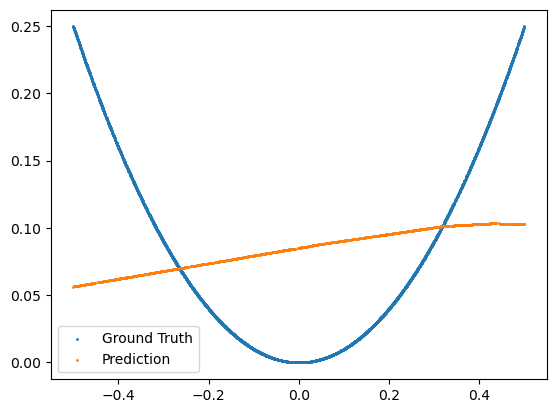

In [8]:
# Plot the results
plt.scatter(x_train.numpy(), y_train.numpy(), label='Ground Truth', s = 1)
plt.scatter(x_test.numpy(), y_pred, label='Prediction', s=1)
plt.legend()
plt.show()

## Numerical Experiment

In this numerical experiment we are going to use the model that we trained and we are going to generate serveral scenarios.
Each scenario consists of a value for the resolution, epsilon we are interested in. In particular we are going to analise the following:

- epsilon = 5
- epsilon = 10
- epsilon = 100
- epsilon = 1024

We are especting to notice a lot of areas where the predicted function shows "bad" behaviours locally

In [ ]:
epsilons = [5, 10, 100, 1024]

for epsilon in epsilons:
    x_unif = np.linspace(-0.5, 0.5, epsilon)
    x_unif = torch.tensor(x_unit).to("cuda")
    

## The MLP regressor

In [30]:
class MLPRegressor(nn.Module):
    """
    Custom MLP regressor with various hyperparameters to set. It ihnerits from the standard nn module of pytorch.
    """

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5, continuous=True):
        """
        Parameters:
            - Embedding sizes, list with 4 tuples with 2 values each
            - Number of continuous variables
            - Output size
            - a list containing the layer structure
            - the drouput probability
            - continuous is a flag that specifies if the values are continuous only (True)
        """
        super().__init__()

        # set the size of the network
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])
        # set the custom dropout probability
        self.emb_drop = nn.Dropout(p)
        # batch normalize the continuous variables to the standard unit scale
        self.bn_cont = nn.BatchNorm1d(n_cont)
        self.cont = continuous

        # it specifies the layer depth in our Network
        layerlist = []
        n_emb = sum((nf for ni, nf in emb_szs))  # sum of the number of features
        n_in = n_emb + n_cont

        # build explicitly the layers in the middle
        for i in layers:
            # the layer at the first input
            layerlist.append(nn.Linear(n_in, i))
            # activation function, in the paper they used the Relu
            layerlist.append(nn.ReLU(inplace=True))
            # normalize the batch
            layerlist.append(nn.BatchNorm1d(i))
            # probability of drop out
            layerlist.append(nn.Dropout(p))
            # number of the layer
            n_in = i

        # output layer
        layerlist.append(nn.Linear(layers[-1], out_sz))

        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cont, x_cat=[]):
        embeddings = []
        # loop through the self-embed variables and append categorical values
        if not self.cont:
            for i, e in enumerate(self.embeds):
                # concatenate the embeddings
                embeddings.append(e(x_cat[:, i]))
            x = torch.cat(embeddings, 1)
            x = self.emb_drop(x)

        x_cont = self.bn_cont(x_cont)
        # concatenate the encoded continuous and the categorical values
        if self.cont == False:
            x = torch.cat([x, x_cont], 1)
            x = self.layers(x)
        else:
            x = torch.cat([x_cont], 1)
            x = self.layers(x)
        return x
    
def set_up_MLP(X, seed, B, L, drop_out_p, info):
    # Use the model
    torch.manual_seed(seed)
    # set the embeddings
    emb_szs = [(0, 0)]
    layers = [B for _ in range(L)]
    model = MLPRegressor(emb_szs, X.shape[1], out_sz=1, layers=layers, p=drop_out_p)
    if info:
        print('[INFO] Model definition')
        print(model)
        print('=' * 80)
    return model

def train(model, y_train, categorical_train, continuous_train,
          learning_rate=0.001, epochs=300, print_out_interval=2, continuous=True):
    global criterion
    criterion = nn.MSELoss()  # we'll convert this to RMSE later
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    start_time = time.time()
    model.train()

    losses = []
    preds = []

    for i in range(epochs):
        i += 1  # Zero indexing trick to start the print out at epoch 1
        if continuous == False:
            y_pred = model(categorical_train, continuous_train, continuous=continuous)
        else:
            y_pred = model(continuous_train)
        preds.append(y_pred)
        loss = torch.sqrt(criterion(y_pred, y_train))  # RMSE
        losses.append(loss)

        if i % print_out_interval == 1:
            print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

        # initialize the problem
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        # take a step in the optimization problem
        optimizer.step()

    print('=' * 80)
    print(f'epoch: {i:3}  loss: {loss.item():10.8f}')  # print the last line
    print(f'Duration: {time.time() - start_time:.0f} seconds')  # print the time elapsed

    return losses, preds

## Initialise the student and the teacher

In [25]:
# Initialize models and loss function
teacher = set_up_MLP(x_train, 42, B=100, L=5, drop_out_p=0.3, info=False).to("cuda")
student = set_up_MLP(x_train, 42, B=100, L=5, drop_out_p=0.3, info=False).to("cuda")
criterion = nn.MSELoss().to("cuda")

Pass the informations from the larger network (teacher) to the smaller (student)

In [26]:
# Train the student model using the knowledge from the teacher model
def train_student(student, teacher, x_train, y_train, criterion, optimizer, num_epochs):
    x_train = torch.tensor(x_train).to("cuda")
    y_train = torch.tensor(y_train).to("cuda")
    
    for epoch in range(num_epochs):
        inputs = torch.tensor(x_train).to("cuda")
        labels = torch.tensor(y_train).to("cuda")
        optimizer.zero_grad()

        # Obtain predictions from the teacher model
        with torch.no_grad():
            losses, teacher_outputs = train(teacher, y_train, x_train, 

        # Use teacher predictions as target for the student model
        student_outputs = student(inputs)
        loss = criterion(student_outputs, teacher_outputs)
        loss.backward()
        optimizer.step()

In [27]:
# Initialize optimizer
optimizer = optim.SGD(student.parameters(), lr=0.0001)

In [28]:
# Train the student model
num_epochs = 1000
train_student(student, teacher, x_train, y_train, criterion, optimizer, num_epochs)

C:\Users\beltr\AppData\Local\Temp\ipykernel_17424\1043102121.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).to("cuda")
C:\Users\beltr\AppData\Local\Temp\ipykernel_17424\1043102121.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).to("cuda")
C:\Users\beltr\AppData\Local\Temp\ipykernel_17424\1043102121.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(x_train).to("cuda")
C:\Users\beltr\AppData\Local\Temp\ipykernel_17424\1043102121.py:8: UserWarnin

Get the predictions

C:\Users\beltr\AppData\Local\Temp\ipykernel_17424\1287792549.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(x).float().to("cuda")


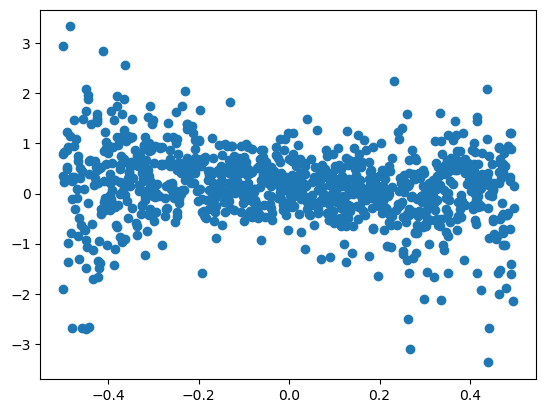

In [29]:
def predict_with_student(student, x):
    with torch.no_grad():
        inputs = torch.tensor(x).float().to("cuda")
        outputs = student(inputs)
        return outputs.cpu().detach().numpy()

y_preds = predict_with_student(teacher, x_test)

plt.scatter(x_test, y_preds, label="Predictions on test data")

We are using a support class that takes a *student teacher* neural network.

In [20]:
# width of the student MLP
hidden_size_s = [10, 20, 30]

#define students and teachers networks
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a student-teacher object
st = StudentTeacher(device='cuda')

# Train the student network
st.fit(x_train, y_train)

C:\Users\beltr\Documents\GitHub\Math_proj\Functions.py:541: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).to("cuda")
C:\Users\beltr\Documents\GitHub\Math_proj\Functions.py:542: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).view(-1, 1).to("cuda")


KeyboardInterrupt: 

In [ ]:
st.plot_loss()
plt.scatter(x_test, st.predict(x_test).cpu().detach().numpy())

In [ ]:
# number of trials per layer width
T = 10
evaluator = ModelEvaluator(x_train, x_test, y_train, y_test, hidden_size_s, T)

In [ ]:
evaluator.train_models()

In [ ]:
evaluator.plot_models(R = 20)
plt.plot(x_init, fx, label="Target function")
plt.show()